# Visualising GLORIA CD37 side-scan sonar data

Author: Ellie Fisher (@efisher008) and Alice Fremand (@almand_BAS)

Date: 07/02/2025

## Aim

The goal of this tutorial is to visualise a seabed feature using GLORIA CD37 side-scan data published by the UK Polar Data Centre.

## Research context and survey background

As part of the Royal Research Ship (RRS) Charles Darwin CD37 research cruise, a side scan sonar called GLORIA (Geological Long Range Inclined Asdic) was operated during January – April 1989. The study area was the Scotia Sea, North Scotia Ridge (NSR), South Sandwich Island, South Sandwich Arc, and West Antarctic Peninsula (WAP) continental shelf, within the broader region of the Southern Ocean.

The major survey areas on CD37 were:
- **South American Antarctic Ridge**: plate motion back to 84Ma
- **Northern South Sandwich trench and fore-arc**: tectonic erosion, tearing of the subducting slab
- **Southern South Sandwich area**: intra-oceanic ridge crest-trench collision
- **Antarctic Peninsula Margin**: ridge crest collision, glacial slope-rise sediment transport
- **Aurora Bank, North Scotia Ridge**: Scotia Sea evolution and Antarctic Circumpolar Current growth

## Scotia Sea geological setting

The history of the Scotia Sea region is complex and still a topic of significant study. Here is a schematic of a recently proposed tectonic setting with key features annotated (taken from Riley et al. 2023). Many of the areas of interest from CD37 are visible on the diagram.

![Tectonics of the Scotia Sea](../images/riley_2023_scotia_tectonics.png "Tectonic setting of the Scotia Sea")
<center><i>Tectonic setting of the Scotia Sea (Riley et al. 2023)</i></center>

GLORIA is a side-scan sonar instrument which acquires acoustic images of the seafloor. Side-scan sonar allows to get an image of the seafloor through an active acoustic swath mapping method in which side-mounted transducers, suspended from a towed object, generate an acoustic signal which is reflected by the seabed and received by the transducer after a delay which is a function of the signal roundtrip travel time through the water column. The intensity of this returned signal enables the differentiation of seafloor features and can be processed into an image. This "image" represents how the sound produced by the sonar instrument interacts with the seabed interface.

The GLORIA instrument used onboard the RRS Charles Darwin on CD37 looked like this:

![Tectonics of the Scotia Sea](../images/GLORIA_instrument.jpg "GLORIA instrument (Science Museum collection)")
<center><i>GLORIA instrument (Science Museum collection)</i></center>

## List of available GLORIA data

The metadata record for the GLORIA CD37 dataset can be found at: 

Barker, P., Livermore, R., Tomlinson, J., Woollett, R., Cunningham, A., Larter, R., Pudsey, C., & Jordan, R. (2025). Geological Long Range Inclined Asdic (GLORIA) seabed side-scan sonar raw data acquired on Charles Darwin CD37 cruise in 1989 (Version 1.0) [Data set]. NERC EDS UK Polar Data Centre. https://doi.org/10.5285/cf87183c-51df-4588-be73-ad0a45fea2d7

The GLORIA CD37 NetCDF files are available from: 
https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=cf87183c-51df-4588-be73-ad0a45fea2d7

## Downloading the data via the Ramadda interface

From the metadata page accessible via the DOI, it is possible to access the data by clicking on ‘GET DATA’. You will then be redirected to our Ramadda repository.

From the interface, it is possible to download the data individually by clicking on the dataset you want to download. It is also possible to zip and download the data together by clickng at the top of the ramadda interface on the down arrow next to “Polar Data Centre > DOI” and Zip and Download Tree:

![GLORIA-CD37-zip-and-download-tree](../images/GLORIA-CD37-zip-and-download-tree.png "Downloading your data with Ramadda")

To download a ZIP file containing all pass files, use the following command (the preceeding ! runs the line as a Linux command):

In [ ]:
!wget "https://ramadda.data.bas.ac.uk/repository/entry/show/UK+Polar+Data+Centre/DOI/Geological+Long+Range+Inclined+Asdic+%28GLORIA%29+seabed+side-scan+sonar+raw+data+acquired+on+Charles+Darwin+CD37+cruise+in+1989/netcdf?entryid=synth%3Acf87183c-51df-4588-be73-ad0a45fea2d7%3AL25ldGNkZg%3D%3D&output=zip.tree"

To download a single file, run the following command:

In [2]:
!wget --content-disposition --trust-server-names "https://ramadda.data.bas.ac.uk/repository/entry/get/CD37_GLORIA_PASS169.nc?entryid=synth%3Acf87183c-51df-4588-be73-ad0a45fea2d7%3AL25ldGNkZi9DRDM3X0dMT1JJQV9QQVNTMTY5Lm5j"

--2025-02-25 14:02:13--  https://ramadda.data.bas.ac.uk/repository/entry/get/CD37_GLORIA_PASS169.nc?entryid=synth%3Acf87183c-51df-4588-be73-ad0a45fea2d7%3AL25ldGNkZi9DRDM3X0dMT1JJQV9QQVNTMTY5Lm5j
Resolving ramadda.data.bas.ac.uk (ramadda.data.bas.ac.uk)... 194.66.5.50
Connecting to ramadda.data.bas.ac.uk (ramadda.data.bas.ac.uk)|194.66.5.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4529928 (4.3M) [application/x-netcdf]
Saving to: ‘CD37_GLORIA_PASS169.nc’

100%[======================================>] 4,529,928   --.-K/s   in 0.1s    

2025-02-25 14:02:13 (32.9 MB/s) - ‘CD37_GLORIA_PASS169.nc’ saved [4529928/4529928]



## Virtual environment

To set up a virtual environment with Conda or Python, please follow the instructions in the GLORIA QC notebook.

## Load the relevant modules

In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import rasterio
import cartopy
from cartopy import crs as ccrs, feature as cfeature
from pyproj import Proj, transform, Transformer
import xarray as xr

## Reading the CD37 GLORIA instrument track

The file `CD37_gloria_track_depth_IBCSO.csv` contains latitude and longitude data recorded from the GPS instrument onboard RRS Charles Darwin. This has been corrected to account for the tow distance of the GLORIA instrument behind the ship. 

We will read this CSV file as a Pandas dataframe.

In [2]:
gloria_track = pd.read_csv("CD37_gloria_track_depth_IBCSO.csv")

## Plotting the GLORIA track

Next, we will set up a standard map plot for the coordinate data (defining a standard projection and extent using the `Cartopy`library).

We will set the map extent using the bounds of the entire CD37 cruise (in the metadata record: https://doi.org/10.5285/cf87183c-51df-4588-be73-ad0a45fea2d7)

In [3]:
# Create a figure with Matplotlib
fig = plt.figure()
fig.set_size_inches(14,14)

# Add a projection and set extent of the axes
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_title("CD37 GLORIA track")
ax.set_extent([-80, 5.0, -70.0, -50]) # West, East, South, North

# Close the figure to suppress display at this point
plt.close()

Plot latitude and longitude data of the instrument track on this map, specifying colour options.

In [4]:
ax.plot(gloria_track['longitude (degree_east)'], gloria_track['latitude (degree_north)'], color="red", linewidth=2)

Add features from Cartopy's Feature Interface (coastlines, land, ocean) using GeoAxes, add gridlines, and display figure in window.

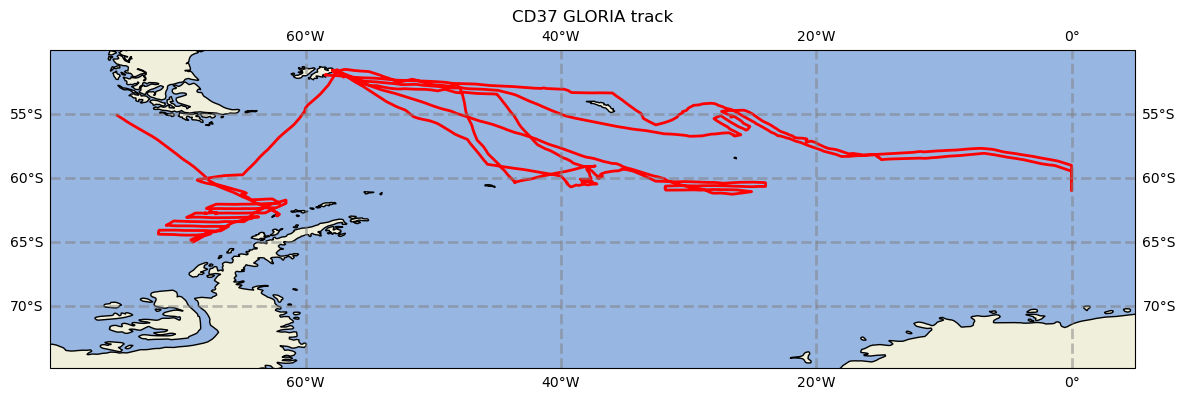

In [5]:
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig

## Plotting data using a different CRS

Antarctic data is usually plotted on a South Polar Stereographic CRS (coordinate reference system). The data are transformed for this projection like so:

Text(0.5, 1.0, 'CD37 GLORIA track')

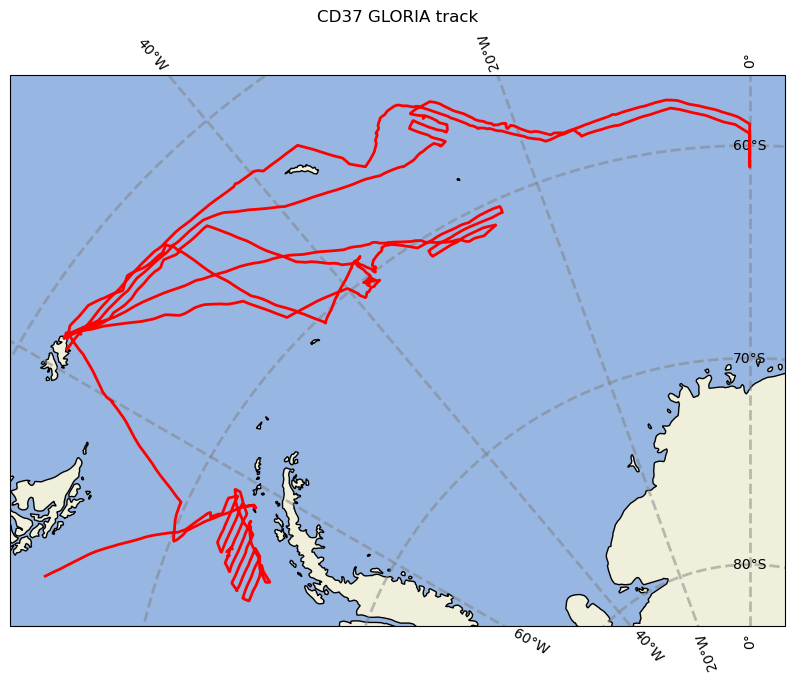

In [6]:
# Define the desired projection
projection = ccrs.SouthPolarStereo()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':projection})

# Add background features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plot latitude and longitude data from GLORIA track
ax.plot(gloria_track['longitude (degree_east)'], gloria_track['latitude (degree_north)'], color="red", linewidth=2, transform=ccrs.PlateCarree())
ax.set_title("CD37 GLORIA track")

## Visualising GLORIA data over a seamount

There is a distinctive feature in pass 169 of the CD37 data. This is a seamount, with a ridge-like shallow bathymetrical profile visible in the quicklook here: https://ramadda.data.bas.ac.uk/repository/entry/get/CD37_GLORIA_PASS169.png?entryid=synth%3Acf87183c-51df-4588-be73-ad0a45fea2d7%3AL3F1aWNrbG9va3MvQ0QzN19HTE9SSUFfUEFTUzE2OS5wbmc%3D.

Let's have a look at the data in more detail by plotting the data of PASS169:

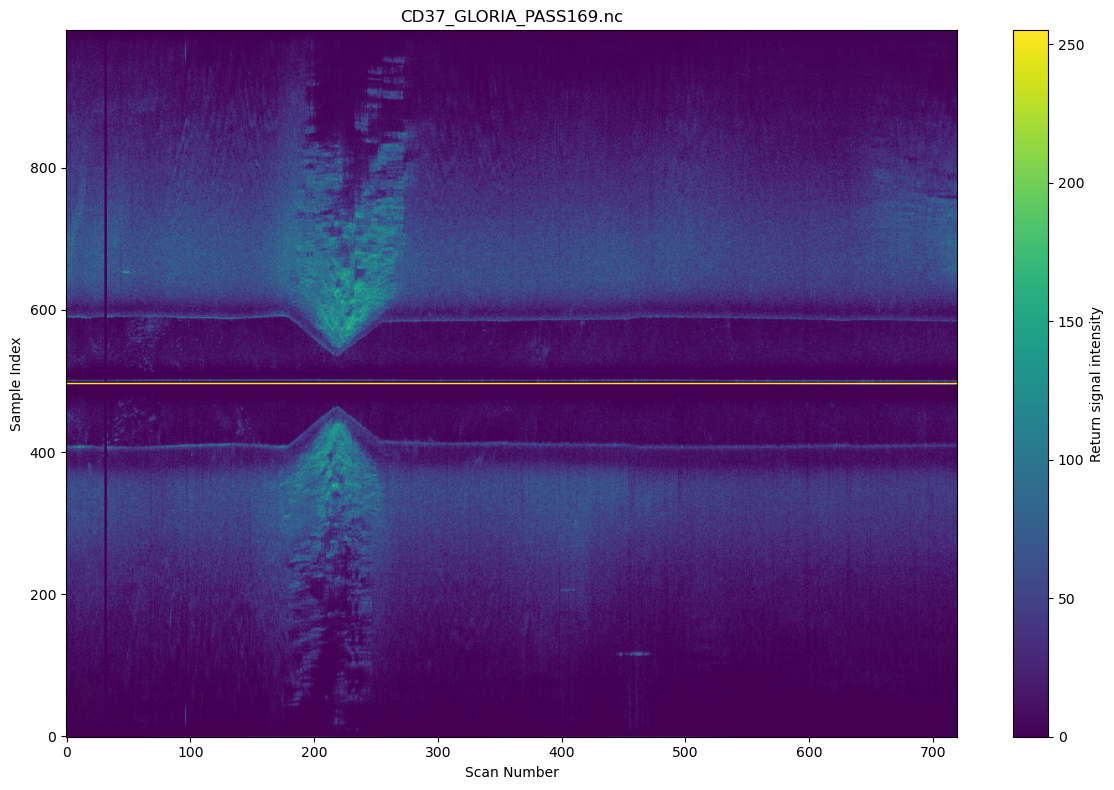

In [7]:
# Open the netCDF file
file_path = "CD37_GLORIA_PASS169.nc"
ds = nc.Dataset(file_path, 'r')

# Initialize a list to store the scan data
scan_data_all = []

# Iterate over all scan groups and collect the data
for group_name in ds.groups:
    group = ds.groups[group_name]
    if 'scan' in group.variables:
        scan_data = group.variables['scan'][:]  # Read all samples
        scan_data_all.append(scan_data)

# Convert the list of scan data into a 2D array (scans x samples)
scan_data_matrix = np.array(scan_data_all)

# Transpose the matrix to swap X and Y axes (scan number becomes X, sample index becomes Y)
scan_data_matrix_transposed = scan_data_matrix.T

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(scan_data_matrix_transposed, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Return signal intensity')
plt.title("CD37_GLORIA_PASS169.nc")
plt.xlabel("Scan Number")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

# Close the dataset
ds.close()



The location of the seamount is at approximately 42.5°W, 59.4°S.

First, we can define the location of the seamount.

In [8]:
# Define the location in latitude and longitude
lat = -59.4  # 59.4°S
lon = -42.5  # 42.5°W

# Define the CRS for EPSG:4326 (lat/lon) and EPSG:9354 (IBCSO projection)
crs_epsg4326 = Proj("EPSG:4326")  # Latitude/Longitude (WGS 84)
crs_epsg9354 = Proj("EPSG:9354")  # IBCSO Projection (EPSG:9354)

# Use Transformer for conversion
transformer = Transformer.from_proj(crs_epsg4326, crs_epsg9354)
center_x, center_y = transformer.transform(lat, lon)  # Note the reversed order: (lat, lon)

print(f"Converted coordinates in EPSG:9354: x={center_x}, y={center_y}")


Converted coordinates in EPSG:9354: x=-2252689.4190089614, y=2458379.1132332776


## Comparing the data with IBCSO

Now we will try to compare the GLORIA data with bathymetry and more precisely the data from the International Bathymetric Chart of the Southern Ocean (IBCSO) version 2. The Digital Bathymetric Model is available to download here: 
https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_RGB.tif (Dorschel et al. 2022).

Let's first download the data:

In [ ]:
!wget "https://download.pangaea.de/dataset/937574/files/IBCSO_v2_bed_RGB.tif"

Now we will check some key information from the IBCSO GeoTIFF file using the `rasterio` library and access the metadata of the file:

In [9]:
# Open the IBCSO GeoTIFF file 
src = rasterio.open('IBCSO_v2_bed_RGB.tif')
# Check the CRS of the dataset and metadata 
print(src.profile)
print(f"Dataset CRS: {src.crs}")

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 19200, 'height': 19200, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-65],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]'), 'transform': Affine(500.0, 0.0, -4800000.0,
       0.0, -500.0, 4800000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
Dataset CRS: EPSG:9354


Now we can plot the full IBCSO map and show the location of the seamount:

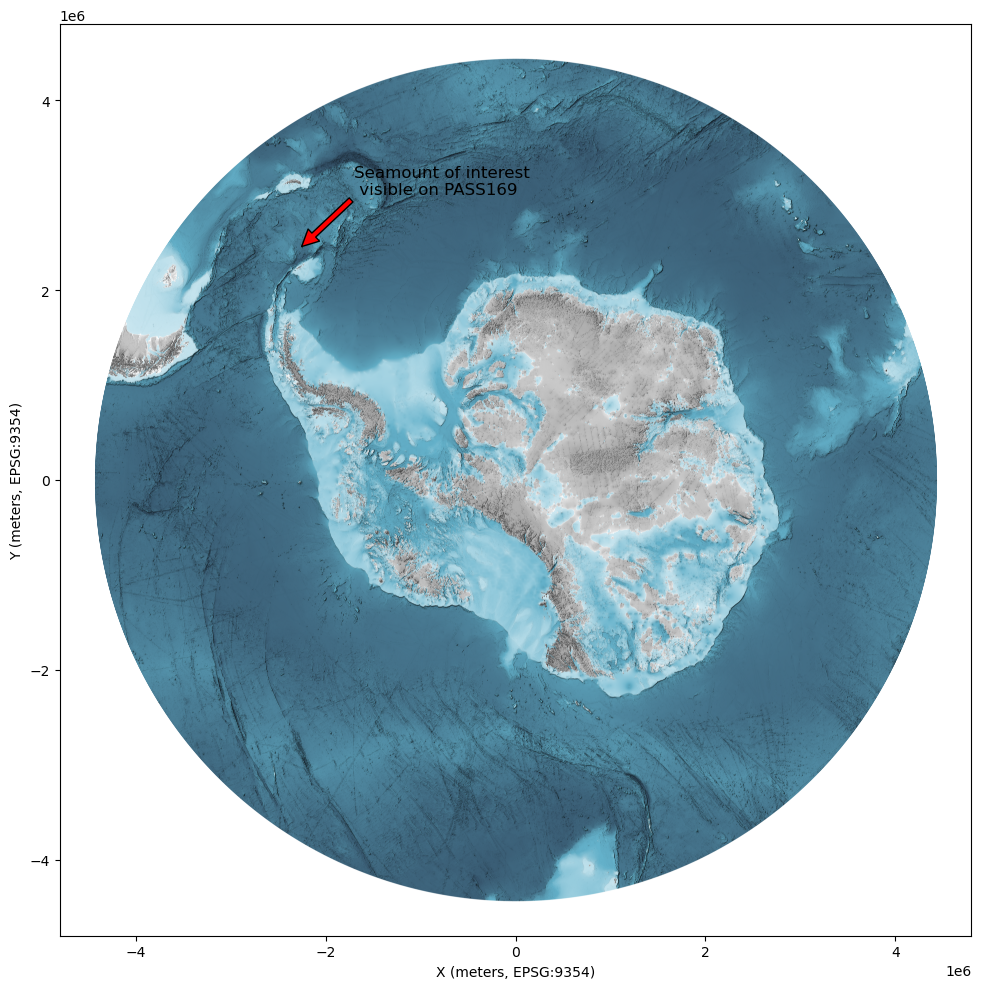

In [10]:
# Read the RGB bands (assuming the GeoTIFF has 3 bands: Red, Green, Blue)
red = src.read(1)  # Read the first band (Red)
green = src.read(2)  # Read the second band (Green)
blue = src.read(3)  # Read the third band (Blue)

# Stack the bands to create an RGB image
rgb = np.stack((red, green, blue), axis=-1)

# Get the affine transform of the dataset
transform = src.transform

# Create an array of X and Y coordinates using the transform
# X coordinates correspond to columns and Y coordinates correspond to rows (i.e. pixel indices)
# We create a grid of coordinates for the full image
x_coords = np.arange(src.width)  # Column indices
y_coords = np.arange(src.height)  # Row indices

# Create meshgrid for X, Y coordinates (this will give us a 2D grid of coordinates)
X, Y = np.meshgrid(x_coords, y_coords)

# Convert pixel coordinates (row, col) to real-world coordinates (X, Y)
real_X, real_Y = transform * (X, Y)  # Apply the affine transform to the entire grid

# Plot the full IBCSO image with real-world coordinates
fig, ax = plt.subplots(figsize=(12, 10))

# We need to plot the image using real-world coordinates
ax.imshow(rgb, extent=(real_X.min(), real_X.max(), real_Y.min(), real_Y.max()))

# Apply real-world coordinates on the axis
ax.set_xlabel("X (meters, EPSG:9354)")
ax.set_ylabel("Y (meters, EPSG:9354)")

# Add annotation for the center with an arrow
ax.annotate('Seamount of interest \n visible on PASS169', 
            xy=(center_x, center_y), 
            xytext=(center_x + 550000, center_y + 550000),  # Offset the text for better visibility
            arrowprops=dict(facecolor='red'),
            fontsize=12, color='black')
# Show the plot
plt.tight_layout()
plt.show()


## Visualising IBCSO depth over the feature

It is also possible to plot the depth profile along the profile. First let's select the data corresponding to the time coverage of our PASS169:

In [11]:
# Creating a Pandas dataframe from the track data.
df = pd.DataFrame(gloria_track)
df['time_gloria'] = pd.to_datetime(df['time_gloria'], format = "%Y-%m-%d %H:%M:%S")

# Indexing the dataframe based on the datetime of the track over the feature.
seamount = df[("1989-03-02 18:00:00" <= df['time_gloria']) & (df['time_gloria'] <= "1989-03-03 00:00:00")]
seamount.head(5)

,time_gloria,longitude (degree_east),latitude (degree_north),depth_IBCSO_v2 (m)
167157,1989-03-02 18:00:00,-43.0247,-59.32270,-4039
167158,1989-03-02 18:00:30,-43.0221,-59.32310,-4040
167159,1989-03-02 18:01:00,-43.0196,-59.32345,-4040
167160,1989-03-02 18:01:30,-43.0171,-59.32380,-4040
167161,1989-03-02 18:02:00,-43.0145,-59.32420,-4040


Now let's have a look at the depth profile along the PASS169 track:

Bounding box (in projection): min_x=-2352689.4190089614, max_x=-2152689.4190089614, min_y=2358379.1132332776, max_y=2558379.1132332776


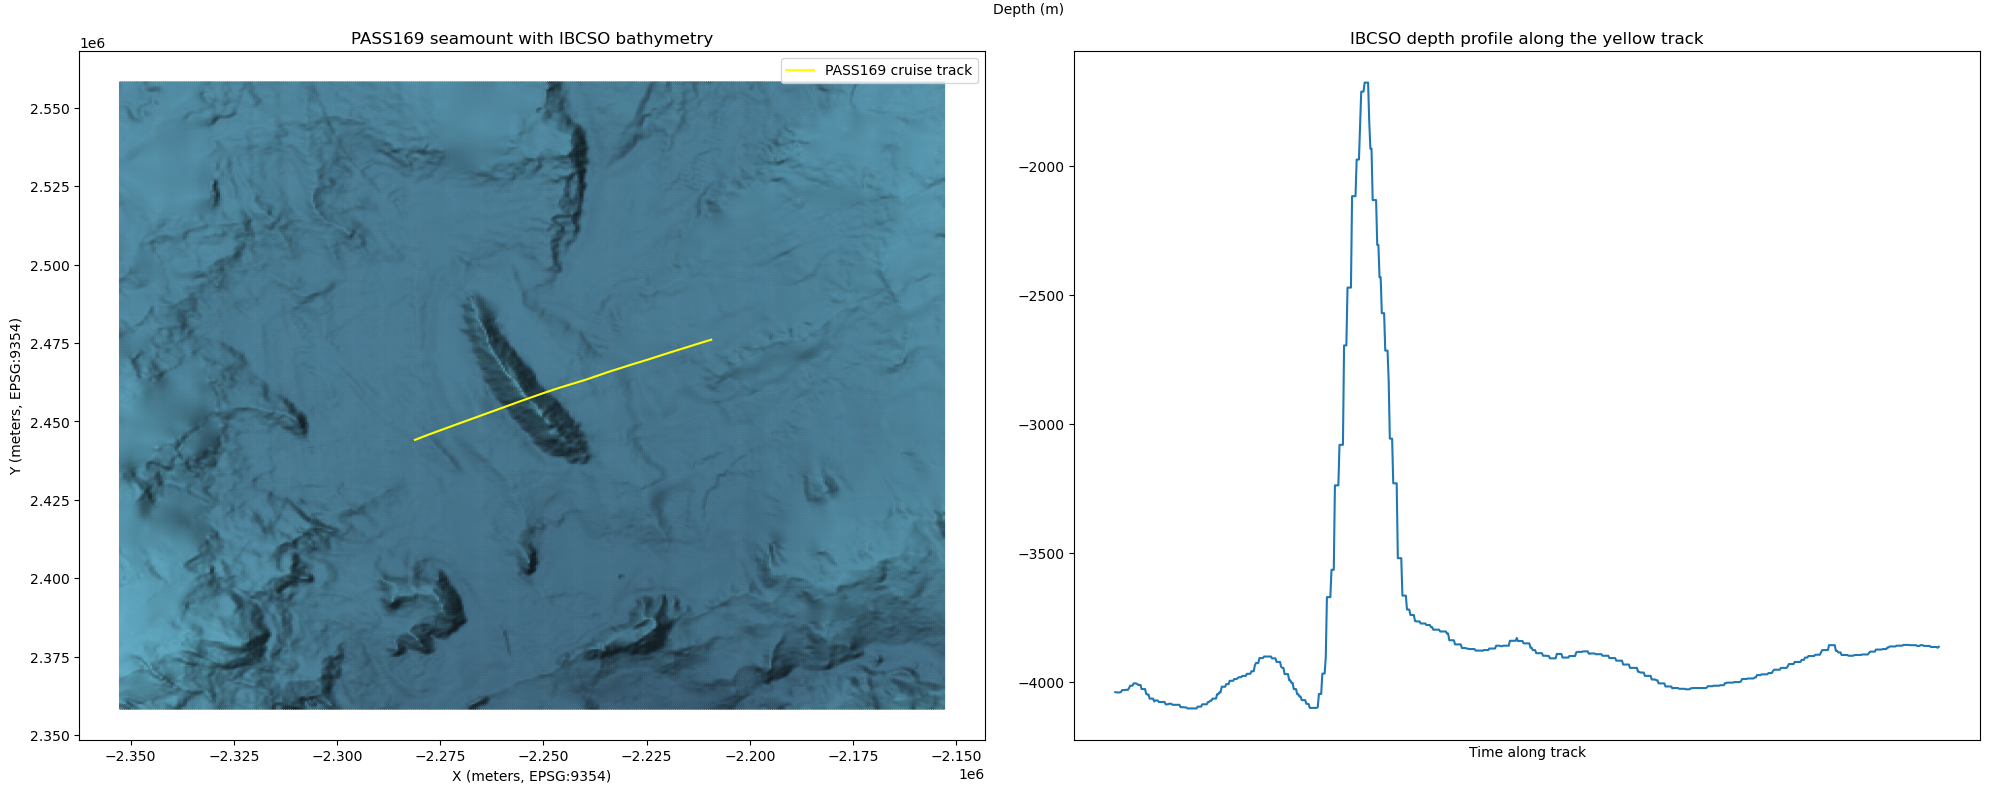

In [12]:
# Convert track lat/lon to EPSG:9354
transformer = Transformer.from_crs("EPSG:4326", "EPSG:9354", always_xy=True)
track_x, track_y = transformer.transform(seamount['longitude (degree_east)'].values, 
                                         seamount['latitude (degree_north)'].values)

radius_m = 100000
min_x = center_x - radius_m
max_x = center_x + radius_m
min_y = center_y - radius_m
max_y = center_y + radius_m

print(f"Bounding box (in projection): min_x={min_x}, max_x={max_x}, min_y={min_y}, max_y={max_y}")

# Directly use real-world coordinates to slice the region (no need to convert back to pixels)
# Find the indices that correspond to the bounding box in real-world coordinates
mask = (real_X >= min_x) & (real_X <= max_x) & (real_Y >= min_y) & (real_Y <= max_y)

# Apply the mask to get the clipped region of the image and corresponding X/Y values
clipped_rgb = rgb[mask].reshape((-1, 3))  # Reshape to a 2D array of RGB values

# Get the corresponding real-world coordinates for the clipped region
clipped_real_X = real_X[mask]
clipped_real_Y = real_Y[mask]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# ---- First subplot: Zoomed-in area with track ----
ax1 = axes[0]
ax1.scatter(clipped_real_X, clipped_real_Y, c=clipped_rgb / 255.0, s=1)  # Seafloor scatter plot
ax1.plot(track_x, track_y, color='yellow', linewidth=1.5, label="PASS169 cruise track")  # Overlay track

ax1.set_xlabel("X (meters, EPSG:9354)")
ax1.set_ylabel("Y (meters, EPSG:9354)")
ax1.legend()
ax1.set_title("PASS169 seamount with IBCSO bathymetry")

# ---- Second subplot: Depth profile along track ----
ax2 = axes[1]
ax2.plot(seamount['time_gloria'], seamount['depth_IBCSO_v2 (m)'])

ax2.set_title("IBCSO depth profile along the yellow track")
ax2.set_xlabel("Time along track")
ax2.set_ylabel("Depth (m)", rotation=0, labelpad=20)
ax2.yaxis.set_label_coords(-0.05, 1.05)
ax2.set_xticks([])  # Hide x-axis ticks

# Adjust layout for better spacing
plt.tight_layout()

# Show both plots
plt.show()

## References

- CD37 889: RRS Charles Darwin Scotia and Bellingshausen Seas Geophysics January 1989 - April 1989 (https://www.bodc.ac.uk/resources/inventories/cruise_inventory/reports/cd37.pdf)  

- Cunningham, Alexander P.. 1998 Geophysical Investigations of the North Scotia Ridge. University of London, PhD Thesis. 

- Riley, T. R., Burton-Johnson, A., Hogan, K. A., Carter, A., & Leat, P. T. (2023). Cretaceous–Paleogene tectonic reconstructions of the South Scotia Ridge and implications for the initiation of subduction in the Scotia Sea. Journal of the Geological Society, 180(4), jgs2023-013.

- Dorschel, Boris; Hehemann, Laura; Viquerat, Sacha; Warnke, Fynn; Dreutter, Simon; Schulze Tenberge, Yvonne; Accetella, Daniela; An, Lu; Barrios, Felipe; Bazhenova, Evgenia A; Black, Jenny; Bohoyo, Fernando; Davey, Craig; de Santis, Laura; Escutia Dotti, Carlota; Fremand, Alice C; Fretwell, Peter T; Gales, Jenny A; Gao, Jinyao; Gasperini, Luca; Greenbaum, Jamin S; Henderson Jencks, Jennifer; Hogan, Kelly A; Hong, Jong Kuk; Jakobsson, Martin; Jensen, Laura; Kool, Johnathan; Larin, Sergey; Larter, Robert D; Leitchenkov, German L; Loubrieu, Benoit; Mackay, Kevin; Mayer, Larry; Millan, Romain; Morlighem, Mathieu; Navidad, Francisco; Nitsche, Frank-Oliver; Nogi, Yoshifumi; Pertuisot, Cécile; Post, Alexandra L; Pritchard, Hamish D; Purser, Autun; Rebesco, Michele; Rignot, Eric; Roberts, Jason L; Rovere, Marzia; Ryzhov, Ivan; Sauli, Chiara; Schmitt, Thierry; Silvano, Alessandro; Smith, Jodie E; Snaith, Helen; Tate, Alex; Tinto, Kirsty; Vandenbossche, Philippe; Weatherall, Pauline; Wintersteller, Paul; Yang, Chunguo; Zhang, Tao; Arndt, Jan Erik (2022): The International Bathymetric Chart of the Southern Ocean Version 2 (IBCSO v2). PANGAEA, doi: 10.1594/PANGAEA.937574